# test timeseries again f-domain integration

In [1]:
from rtergpy.waveforms import getwaves,wave2energy,stepthroughwaves,loadwaves
from obspy import UTCDateTime
from tqdm import tqdm
import numpy as np
eloc = [13.80,120.50,104]
etime= UTCDateTime(2021,7,23,20,49,00)   # recent M7 in eastern Indonesia
#get new data
#st,df=getwaves(eloc,etime)
# get locally stored data
eventname='2021072300'
st,df=loadwaves(eventname) # assumes iteration zero if not included

In [2]:
from scipy.fftpack import fft,ifft
from rtergpy.waveforms import process_waves,tstar
from numpy import pi,exp

tstart=-5; tlength=300
fmin=1/70; fmax=5
tr=st[40].copy()
t1cut=tr.stats.phasePtime-tstart 
t2cut=t1cut+tlength
trslice=tr.slice(t1cut,t2cut)
tr=process_waves(trslice,freqmin=fmin,freqmax=fmax)
tr.resample(10)
#tr=trslice
trf=fft(tr)
# # recreating obspy.freqatributes.spectrum
n1=0; n2=len(tr)
n=n2-n1
srate=tr.stats.sampling_rate
print("srate =",srate)
dt=1/srate    
f=np.linspace(0,srate/2,n)

# for testing run the following in the data directory:
#trffo=np.full_like(trf.real,0)
trfts=np.full_like(trf.real,0)
epf=np.full_like(trf.real,0)
sinu=np.full_like(trf.real,0)
# printf "II.WRAB_.00.BHZ.SAC\nII.WRAB_.00.BHZ.SAC.pz\n300\n1\n"  | /home/jconvers/EQerg/CWBerg/src/nergy_wprep.cwb.wderivs_outputfft
# integration prep 
#sinu=0
for j in range(0,len(f)-1):
    if (f[j]>fmin) & (f[j]<=fmax):
        #trfts[j]= abs(trf[j])*(exp(2*pi*f[j]*tstar(f[j])))**.5
        trfts[j]= trf[j].real*(exp(2*pi*f[j]*tstar(f[j])))**.5
        #trffo[j]= abs(trf[j])#*(exp(2*pi*f[j]*tstar(f[j])))**.5
        #epf[j] = abs(trf[j])**2 #*exp(2*pi*f[j]*tstar(f[j])) # energy per frequency
        sinu[j] = abs(trf[j])**2 *exp(2*pi*f[j]*tstar(f[j])) # energy per frequency
    else:
        a=0;
        trfts[j] = trf[j].real
    sinusum = 2*pi*dt/n * sum(sinu) # not 100% on the 2pi
#equivelent results
print("full df integration =", 2*pi*dt/n*sum(abs(trf)**2))
print("full dt integration =", 2*pi*dt  *sum(abs(tr.data)**2))
print("f-bound df integration (corrected) =", sinusum)
tts=ifft(trfts.real+1j*trf.imag) 
tts=ifft(trfts.real+1j*trf.imag) 
Etsc=2*pi*dt *sum(abs(tts)**2)
print("f-bound dt integration (corrected) =", Etsc)
print("time series integration (%.2e) is almost f-series integration(%.2e)" %(Etsc, sinusum))

srate = 10.0
full df integration = 2.21422501626e-09
full dt integration = 2.21422501626e-09
f-bound df integration (corrected) = 0.000632580877561
f-bound dt integration (corrected) = 0.000300225267394
time series integration (3.00e-04) is almost f-series integration(6.33e-04)


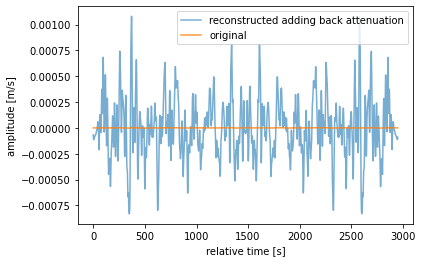

In [3]:
import matplotlib.pyplot as plt 

#itr=fft(tr)
#tts=ifft(trfts.real+1j*trf.imag)  # w/atten corr.
#ttsfo=ifft(trffo.real+1j*trf.imag) # wo/atten corr.
plt.plot((tts.real),label="reconstructed adding back attenuation",alpha=0.6);
plt.plot(tr.data,label="original",alpha=0.8);
#plt.plot(ttsfo.real,label="reconstructed-fo");
plt.ylabel('amplitude [m/s]')
plt.xlabel('relative time [s]')
plt.legend()
plt.show;
#E=2*pi*dt*sum((ttsfo.real)**2)
#print ("full waveform energy: ", 2*pi*dt*sum((tr.data)**2))
#print("time series integration (%.2e) is almost f-series integration(%.2e)" %(E, sinu))
#plt.show;

# Attenuation-based amplification factor

basic plotting, to see where this really contributes in terms of waveform amplitude

at f= 0.0142857142857 [Hz] amplication is 1.04987665536
at f= 2.0 [Hz] amplication is 19.1528193439


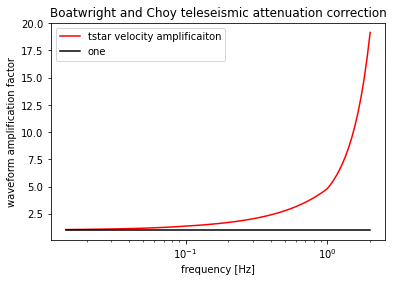

In [4]:
def tstaramp(f):
    amp=list()
    for fi in f:
        amp.append(exp(2*pi*fi*tstar(fi))**.5)
    return amp

f=np.logspace(np.log10(1/70),np.log10(2),num=100)
tamp=tstaramp(f)
plt.plot(f,tamp,'r-',label="tstar velocity amplificaiton")
plt.plot(f,1+0*f,'k-',label="one")
plt.legend()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('frequency [Hz]')
plt.ylabel('waveform amplification factor')
plt.title('Boatwright and Choy teleseismic attenuation correction')
print("at f=",f[0], "[Hz] amplication is", tamp[0])
print("at f=",f[-1], "[Hz] amplication is", tamp[-1])
plt.show()

In [7]:
ts=list()
for fi in f: 
    ts.append(tstar(fi))



/Users/anewman/Documents/Projects/rterg/processing/rtergpy/waveforms.py:182: RuntimeWarning: divide by zero encountered in log10
  tst=0.9-0.1*log10(f)


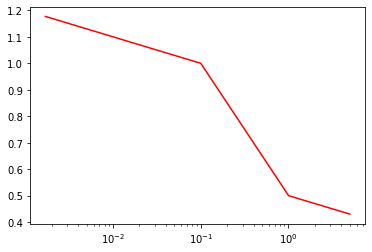

In [10]:
plt.plot(f,ts, 'r-')
plt.xscale('log')
# these don't seem to correspond to the results in Choy and Cormier (1986--need to further investigate)
# actually from Choy and Boatwright 1995 (which they derived from Choy and Cormier (1986))